<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Извлекаем-леммы" data-toc-modified-id="Извлекаем-леммы-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Извлекаем леммы</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#About-BERT-(вопросы,-после-того-как-закончим-с-проектом)-:)" data-toc-modified-id="About-BERT-(вопросы,-после-того-как-закончим-с-проектом)-:)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>About BERT (вопросы, после того как закончим с проектом) :)</a></span></li></ul></div>

# Разработка модели определения фейковых новостей

Требуется разработать модель, которая будет способна различать заголовки реальных и выдуманных новостей.

Для обучения модели используйте данные из файла `train.tsv`. В файле находится таблица, состоящая из двух колонок. 
В колонке title записан заголовок новости. В колонке is_fake содержатся метки: 0 – новость реальная; 1 – новость выдуманная.
Для демонстрации работы модели используйте данные тестового набора из файла `test.tsv`. В нем также есть колонка title, данные которой являются входными для вашей модели.

Вам нужно скопировать файл `test.tsv`, переименовать его в `predictions.tsv` и заполнить колонку is_fake значениями предсказаний вашей модели, аналогично `train.tsv`. 

Изначально колонка заполнена значением 0.

## Подготовка

### Import

In [4]:
!pip install CatBoost
!pip install -U spacy
!pip install langdetect
!spacy download ru_core_news_md
!pip install transformers

     |████████████████████████████████| 76.6 MB 1.1 MB/s 
     |████████████████████████████████| 6.0 MB 14.7 MB/s 
     |████████████████████████████████| 42 kB 1.7 MB/s 
     |████████████████████████████████| 653 kB 53.8 MB/s 
     |████████████████████████████████| 457 kB 52.3 MB/s 
     |████████████████████████████████| 181 kB 62.4 MB/s 
     |████████████████████████████████| 10.1 MB 48.5 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstal

In [5]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

import re

import nltk
from nltk.corpus import stopwords as nltk_stopwords
import spacy
from langdetect import detect

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import torch
import transformers

from tqdm import notebook

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

#Global
random_state=12345

In [7]:
data = pd.read_table('train.tsv')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


В тренировочном датасете 5758 семплов. Явных пропусков нет. Рассмотрим как выглядят записи в датасете.

In [9]:
# 20 рандомных записей
data.sample(20)

,title,is_fake
590,Дэвид Боуи и группа Cream получат Грэмми за вк...,0
3757,ВТБ записали в покупатели еще одного крупного ...,0
5457,Налоговая Ленобласти предложила девушкам сдать...,1
1491,Раскрыто «шокирующее» число жертв насильников ...,0
5137,Лидер партии «Родина» предложил «забить стрелу...,1
3959,Овечкин набрал два очка в матче НХЛ,0
3920,Рэпер Гнойный станет членом жюри вокального шо...,0
3772,"Вместо асфальта — эко-опилки, дома из природны...",1
4962,Госдума одобрила Международное соглашение по к...,0
704,В России запретят выдавать кредиты меньше милл...,1


### Анализ

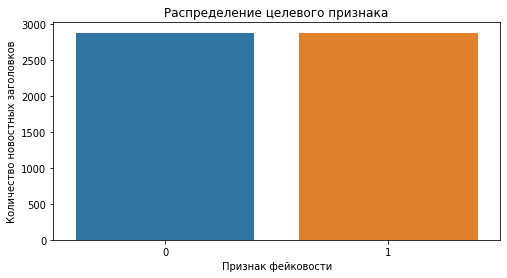

In [10]:
# Сравним количество фейковых и действительных новостных заголовков

plt.figure(figsize=(8,4))
sns.barplot(x=data['is_fake'], y=data['is_fake'].value_counts())
plt.title('Распределение целевого признака')
plt.xlabel('Признак фейковости')
plt.ylabel('Количество новостных заголовков')
plt.show()

Судя по графику их количество должно совпадать.

Дисбаланса классов нет.

In [11]:
data['is_fake'].value_counts()

1    2879
0    2879
Name: is_fake, dtype: int64

Количество фейковых и действительных заголовоков совпадает.

На первый взгляд, основной язык новостных заголовков - русский. Проанализируем так ли это на самом деле.

In [12]:
# Детекция языка используемого в заголовке

data['lang'] = data['title'].apply(lambda x: detect(x))
data.head()

,title,is_fake,lang
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,ru
1,Агент Кокорина назвал езду по встречке житейск...,0,ru
2,Госдума рассмотрит возможность введения секрет...,1,ru
3,ФАС заблокировала поставку скоростных трамваев...,0,ru
4,Против Навального завели дело о недоносительст...,1,ru


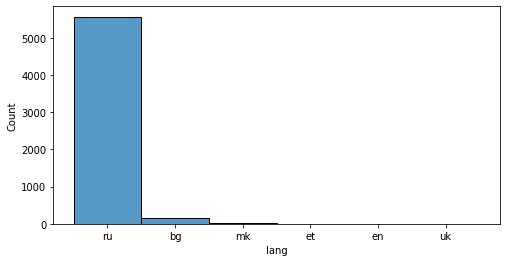

In [13]:
# Оценим детектором на каких языках имеются заголовки в датасете

plt.figure(figsize=(8,4))
sns.histplot(data['lang'])
plt.show()

По графику, в датасете есть заголовки на 6 иностранных языках.
Рассмотрим, так ли это на самом деле.

In [14]:
data[data['lang'] != 'ru'].groupby(data['lang'])
for key, group in iter(data[data['lang'] != 'ru'].groupby(data['lang'])):
  print(key, group)
  print(f'Количество заголовков на языке {key} = {len(group)}', '\n')

bg                                                   title  is_fake lang
14          Режиссера Алексея Германа наградили орденом        0   bg
48    Интересы Газпромбанка защитят два американских...        0   bg
51    В РПЦ призвали предать анафеме Илона Маска из-...        1   bg
266   Давида Микеланджело защитят от грязи с помощью...        0   bg
303    Динара Сафина вышла в 1/8 финала Australian Open        0   bg
...                                                 ...      ...  ...
5623                 Пиво Миллер станет южноафриканским        0   bg
5709                  Дацюк набрал три очка в матче НХЛ        0   bg
5723     Терек подал жалобу на судейство матча с Динамо        0   bg
5732          Вдова Джорджа Харрисона посвятила ему сад        0   bg
5756   Туркмения в декабре начнет поставки газа в Китай        0   bg

[151 rows x 3 columns]
Количество заголовков на языке bg = 151 

en                                                   title  is_fake lang
1706              

На самом деле, все заголовки на русском языке. Детектор опознал язык отличный от русского в случаях с аббревиатурами и с преобладанием в заголовках иностранных имен, компаний и названий продуктов.

In [15]:
# Есть ли зависимость между длиной заголовка и его правдоподобностью

data['len'] = pd.Series([len(x) for x in data['title']])

# нормализация значений длины
data['len'] = round(data['len'] / max(data['len']), 2) 
data.head()

,title,is_fake,lang,len
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,ru,0.36
1,Агент Кокорина назвал езду по встречке житейск...,0,ru,0.27
2,Госдума рассмотрит возможность введения секрет...,1,ru,0.36
3,ФАС заблокировала поставку скоростных трамваев...,0,ru,0.27
4,Против Навального завели дело о недоносительст...,1,ru,0.28


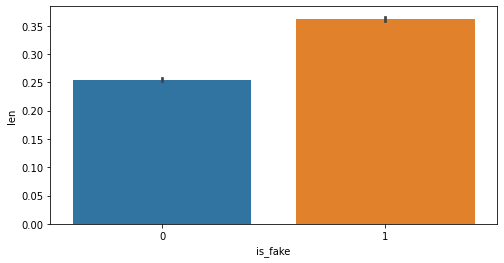

In [16]:
plt.figure(figsize=(8,4))
sns.barplot(x=data['is_fake'], y = data['len'])
plt.show()

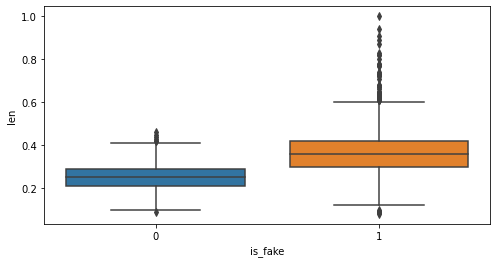

In [17]:
plt.figure(figsize=(8,4))
sns.boxplot(x=data['is_fake'], y = data['len'])
plt.show()

Фейковые новости в среднем длинее подлиных.

#Tf-idf

### Извлекаем леммы

In [18]:
nltk.download('stopwords') # извлечение стоп слов

nlp = spacy.load('ru_core_news_md') # из библиотеки spacy загружаем pipeline русского текста СМИ

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
# функция удаления лишних символов и стоп слов + выделение лемма

def lemm_clear_text(title):
    # очищаем от лишних символов
    title_without_sw = re.sub(r'[^а-яёЁА-Яa-zA-Z0-9]', ' ', title) 
    
    # очищаем строку от стоп слов
    text = [word.lower() for word in title_without_sw.split() if word.lower() not in set(nltk_stopwords.words('russian'))]
    text =  " ".join(text)

    # извлечение лемм (lib Scapy)
    result_text = [word.lemma_ for word in nlp(text)]

    return " ".join(result_text)

In [20]:
# Применеие функции lemm_clear_text к заголовкам статей
data['lemm_title'] = data['title'].apply(lemm_clear_text)
data.sample(10)

,title,is_fake,lang,len,lemm_title
5461,NASA: из-за глобального потепления уже через 1...,1,ru,0.50,nasa глобальный потепление 10 год погибнуть ки...
3340,Алексей Навальный отказался от еды до конца св...,1,ru,0.33,алексей навальный отказаться еда конец священн...
1152,Звезда «Зачарованных» вступилась за свою вагин...,0,ru,0.35,звезда зачаровать вступиться вагин обматерить ...
3930,Министр нефти Кувейта предсказал снижение ее ц...,0,ru,0.30,министр нефть кувейт предсказать снижение цена...
2473,Прибор наведения противотанковых ракет приспос...,0,ru,0.34,прибор наведение противотанковый ракета приспо...
4174,Выкупивший картину Папича за 1 миллион рублей ...,1,ru,0.38,выкупить картина папича 1 миллион рубль продат...
4048,Из-за низкой платёжеспособности населения Росп...,1,ru,0.43,низкий платёжеспособность население роспотребн...
2929,Тверской суд обязал Германию оплатить восстано...,1,ru,0.36,тверской суд обязать германия оплатить восстан...
110,Депутаты Думы устроили давку и драку во время ...,1,ru,0.40,депутат дума устроить давка драка время распро...
4135,Средняя зарплата в Москве впервые превысила 40...,0,ru,0.28,средний зарплата москве впервые превысить 40 т...


In [21]:
# создаем признаки для дальнейшей векторизации и обучения
features_corp = data['lemm_title'].values
target = data['is_fake']

In [22]:
features_train, features_valid, target_train, target_valid = \
train_test_split(features_corp, target, test_size=0.2, random_state=random_state)

In [23]:
count_tf_idf = TfidfVectorizer()

features_train = count_tf_idf.fit_transform(features_train)
features_valid = count_tf_idf.transform(features_valid)

## Обучение + Валидация

In [24]:
dictionary_models = {} #словарь моделей, для записи метрик и гиперпараметров

In [25]:
# функция для подбора гиперпараметров и расчета метрик
def model_tuning(model, params):
  clf = GridSearchCV(
    estimator=model,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='f1'
  )

  clf.fit(features_train, target_train)
  
  f1_train = f1_score(target_train, clf.predict(features_train))
  f1_valid = f1_score(target_valid, clf.predict(features_valid))

  print(f'f1_train = {f1_train}, f1_valid = {f1_valid}', '\n')

  # Confusion_matrix_for_valid
  plot_confusion_matrix(clf, features_valid, target_valid)
  plt.title('Confusion_matrix_for_valid')
  plt.show()

  return [clf.best_params_,
          f1_train,
          precision_score(target_train, clf.predict(features_train)),
          recall_score(target_valid, clf.predict(features_valid)),
          f1_valid,
          precision_score(target_valid, clf.predict(features_valid)),
          recall_score(target_valid, clf.predict(features_valid))
          ]

### LogisticRegression

Fitting 5 folds for each of 14 candidates, totalling 70 fits
f1_train = 1.0, f1_valid = 0.8445199660152931 



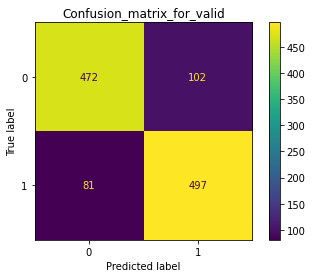

In [26]:
dictionary_models['LogisticRegression_tf_idf'] = \
model_tuning(model=LogisticRegression(random_state=random_state),
             params = {
                'penalty' : ['l1', 'l2'],
                'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'solver' : ['liblinear']
                }
             )

Проверка на валидационной выборке показывает, FP и FN - показывают значения порядка 100 записей каждый.

### RandomForestClassifier

In [27]:
clf = RandomForestClassifier(random_state=random_state)
clf.fit(features_train, target_train)

f1_train = f1_score(target_train, clf.predict(features_train))
f1_valid = f1_score(target_valid, clf.predict(features_valid))

dictionary_models['RandomForestClassifier_tf_idf'] = \
[
 clf.get_params,
 f1_train,
 precision_score(target_train, clf.predict(features_train)),
 recall_score(target_valid, clf.predict(features_valid)),
 f1_valid,
 precision_score(target_valid, clf.predict(features_valid)),
 recall_score(target_valid, clf.predict(features_valid))
 ]

f1_train = 1.0, f1_valid = 0.764 



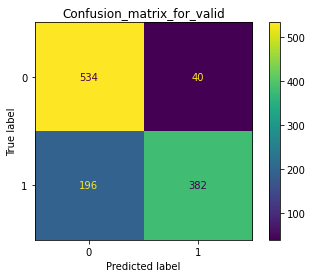

In [28]:
print(f'f1_train = {f1_train}, f1_valid = {f1_valid}', '\n')

plot_confusion_matrix(clf, features_valid, target_valid)
plt.title('Confusion_matrix_for_valid')
plt.show()

Модель RandomForestClassifier показала результаты метрики f1 ниже чем LogisticRegression. Ошибочно фейковых меньше, но увеличилось количество фейковых новостей определенных как действительные.

### CatBoostClassifier

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 0.6873686	total: 116ms	remaining: 1m 55s
500:	learn: 0.2802397	total: 27.4s	remaining: 27.3s
999:	learn: 0.1854443	total: 54.5s	remaining: 0us
f1_train = 1.0, f1_valid = 0.7958214624881291 



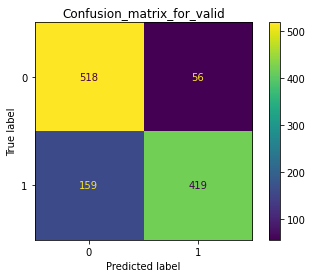

In [29]:
dictionary_models['CatBoostClassifier_tf_idf'] = \
model_tuning(model=CatBoostClassifier(random_state=random_state),
             params = {
                'learning_rate' : list(np.arange(0.1,0.5,0.1)),
                'loss_function': ['Logloss'],
                'verbose': [500]
                }
             )

Модель CatBoostClassifier отработала лучшем чем RandomForest, но модель так же определяет большое количество фейкоых заголовков, как действительные.

# Bert

Создадим эмбеддинги с помощью модели RuBERT.

## Создание эмбеддингов

In [31]:
def create_embeddings(features, batch_size):
  #токенизация
  tokenizer = transformers.BertTokenizer(
    vocab_file='/Bert/vocab.txt')

  tokenized = features.apply(
      lambda x: tokenizer.encode(x, add_special_tokens=True))

  # создание маски для важных токенов
  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

  attention_mask = np.where(padded != 0, 1, 0)

  #инициализация конфигурации и модели

  config = transformers.BertConfig.from_json_file('/Bert/config.json')
  model = transformers.BertModel.from_pretrained('/Bert/pytorch_model.bin', config=config)
  
  #создание эмбеддингов

  embeddings = []
  for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
          batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
          attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
          
          with torch.no_grad():
              batch_embeddings = model(batch, attention_mask=attention_mask_batch)
          
          embeddings.append(batch_embeddings[0][:,0,:].numpy())

  return embeddings

## Подготовка признаков

In [32]:
features = np.concatenate(create_embeddings(data['title'], batch_size=50))
target = data['is_fake'].iloc[0:features.shape[0]]

features_train, features_valid, target_train, target_valid = \
train_test_split(features, target, test_size=0.2, random_state=random_state)

Some weights of the model checkpoint at /content/drive/MyDrive/Kontur/Bert/pytorch_model.bin were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/115 [00:00<?, ?it/s]

## Обучение + Валидация

### LogisticRegression

Fitting 5 folds for each of 14 candidates, totalling 70 fits
f1_train = 0.8834248079034027, f1_valid = 0.8668407310704961 



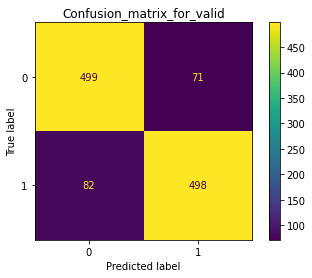

In [33]:
dictionary_models['LogisticRegression_bert'] = \
model_tuning(model=LogisticRegression(random_state=random_state),
             params = {
                'penalty' : ['l1', 'l2'],
                'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'solver' : ['liblinear']
                }
             )

### RandomForestClassifier

In [34]:
clf = RandomForestClassifier(random_state=random_state)

clf.fit(features_train, target_train)

f1_train = f1_score(target_train, clf.predict(features_train))
f1_valid = f1_score(target_valid, clf.predict(features_valid))

dictionary_models['RandomForestClassifier_bert'] = \
[
 clf.get_params,
 f1_train,
 precision_score(target_train, clf.predict(features_train)),
 recall_score(target_valid, clf.predict(features_valid)),
 f1_valid,
 precision_score(target_valid, clf.predict(features_valid)),
 recall_score(target_valid, clf.predict(features_valid))
 ]

f1_train = 1.0, f1_valid = 0.8217317487266553 



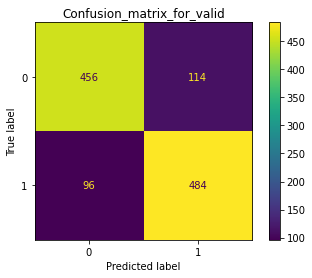

In [35]:
print(f'f1_train = {f1_train}, f1_valid = {f1_valid}', '\n')

# Confusion_matrix_for_valid
plot_confusion_matrix(clf, features_valid, target_valid)
plt.title('Confusion_matrix_for_valid')
plt.show()

### CatBoostClassifier

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 0.6615810	total: 287ms	remaining: 4m 47s
500:	learn: 0.0170104	total: 1m 47s	remaining: 1m 46s
999:	learn: 0.0039655	total: 3m 33s	remaining: 0us
f1_train = 1.0, f1_valid = 0.8554421768707482 



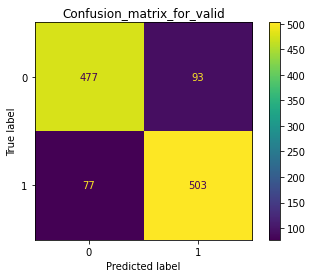

In [36]:
dictionary_models['CatBoostClassifier_bert'] = \
model_tuning(model=CatBoostClassifier(random_state=random_state,
                                      verbose=500,
                                      loss_function='Logloss'),
             params = {
                'learning_rate' : list(np.arange(0.1,0.5,0.1)),
                }
             )

##Таблица с результатами обучения

In [37]:
pivot_table = pd.DataFrame(dictionary_models, index=[
                                                     'params',
                                                     'f1_train',
                                                     'precision_train',
                                                     'recall_train',
                                                     'f1_valid',
                                                     'precision_valid',
                                                     'recall_valid'])
pivot_table = pivot_table.drop(index=['params'])
pivot_table.T      

,f1_train,precision_train,recall_train,f1_valid,precision_valid,recall_valid
LogisticRegression_tf_idf,1.0,1.0,0.859862,0.84452,0.829716,0.859862
RandomForestClassifier_tf_idf,1.0,1.0,0.6609,0.764,0.905213,0.6609
CatBoostClassifier_tf_idf,1.0,1.0,0.724913,0.795821,0.882105,0.724913
LogisticRegression_bert,0.883425,0.891054,0.858621,0.866841,0.87522,0.858621
RandomForestClassifier_bert,1.0,1.0,0.834483,0.821732,0.809365,0.834483
CatBoostClassifier_bert,1.0,1.0,0.867241,0.855442,0.84396,0.867241


## Вывод

В результате обучения, лучшие показатели метрики f1 показала модель LogisticRegression (среди других моделей), независимо от способа преобразования текста.

Показатель метрики f1 на валидациооной выборке у LogisticRegression, при преобзовании текста в эмбеддинги с помощью модели RuBERT выше, чем с векторизацией tf-idf. Выигрываем в метрике, проигрываем по времени выполнения. 

Используем данну модель (LogisticRegression (RuBERT)), для дальнейшего предсказания на тестовой выборке.

# Тестовая выборка

In [38]:
data_test = pd.read_table('test.tsv')
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1000 non-null   object
 1   is_fake  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [39]:
data_test.sample(10)

,title,is_fake
434,Александр Емельяненко нокаутировал бразильца з...,0
125,Международный союз биатлонистов обвинили в сок...,0
214,Навальный приобрёл виллу на берегу озера Комо,0
615,Новый порядок госзакупок за год сэкономит 230 ...,0
128,Индекс РТС поднялся до максимума с сентября 20...,0
471,Пенсионерам выплатят по 500 рублей за обещание...,0
223,Голодец попросила Путина повысить МРОТ,0
427,В России отменят право на отказ от прививок и ...,0
953,Газпром и Нафтогаз поправили газовые контракты...,0
250,"Пенсионеры, не получившие подарочных карт на в...",0


## Подготовка признаков

In [40]:
features_test = np.concatenate(
    create_embeddings(data_test['title'], batch_size=50)
    )

Some weights of the model checkpoint at /content/drive/MyDrive/Kontur/Bert/pytorch_model.bin were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/20 [00:00<?, ?it/s]

Для итогового предсказания обучим LogisticRegression на всем датасете train.

In [41]:
params = dictionary_models['LogisticRegression_bert'][0]

In [42]:
model = LogisticRegression(random_state=random_state).set_params(**params)
model.fit(features, target)

# оценим усредненную метрику f1 на всем датасете
scores = cross_val_score(model, features, target, scoring='f1')
scores.mean()

0.8587888335350318

##Предсказание

In [43]:
data_test['is_fake'] = model.predict(features_test)

Оценим количество предсказаний

In [44]:
data_test['is_fake'].value_counts()

0    507
1    493
Name: is_fake, dtype: int64

##Запись в файл

In [45]:
data_test.to_csv('predictions.tsv', index=False, sep='\t')

# Благодарности

Благодарю вашу команду за создание интересного задания, отличную поддержку в виде чата и возможность участовать в подобных контестах!